In [162]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [163]:
#Identify experiments that are not in the ignore list 
exp_test_description = "LLMP_Experiments_v3"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

ignore_list = [".csv",
               "ipynb",
#                 "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
#                "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
               "human",
               "llama-3.1-70B_exo_code_desc_False_75_item",
               "llama-3.1-70B_future_exo_code_desc_False_75_item",
#                "code",
#                "GPT_P",
#                "exp2_R"
#                "llm",
#                "exp1",
#                "report", 
#                "covariates",
               
]

experiments_include = []

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments_include.append(experiment_name)

experiments_include

['gpt-4o_future_english_desc_False_25_report_False_median',
 'claude-3-5-sonnet-20241022_price_english_desc_False_75_report_pdf_median',
 'gemini-1.5-pro_future_english_desc_True_full_report_False_median',
 'gpt-4o_exo_code_desc_True_75_report_False_median',
 'gpt-4o_exo_english_desc_False_full_report_False_median',
 'claude-3-5-sonnet-20241022_exo_code_desc_True_10_report_False_median',
 'gemini-1.5-pro_future_english_desc_True_75_report_False_median',
 'gpt-4o_future_exo_code_desc_True_full_report_False_median',
 'gpt-4o_price_english_desc_False_full_report_False_median',
 'gemini-1.5-pro_exo_code_desc_True_10_report_False_median',
 'claude-3-5-sonnet-20241022_price_english_desc_False_full_report_False_median',
 'gemini-1.5-pro_price_english_desc_False_75_report_pdf_median',
 'gemini-1.5-pro_future_exo_english_desc_True_75_report_pdf_median',
 'gpt-4o_exo_code_desc_False_25_report_False_median',
 'gemini-1.5-pro_price_english_desc_False_full_report_False_median',
 'claude-3-5-sonnet-

In [164]:

report_sim_dates = open("../generate_forecasts/experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:1]



llmp_target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Meat',
     'Vegetables and vegetable preparations'
]
target_categories = llmp_target_categories



target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

In [165]:
# # Define the source directory (starting from Full_Report)
# source_dir = "../generate_forecasts/output/Full_Report/"
# # No need to hard-code the destination directory here; it will be determined dynamically

# # Walk through the source directory to find the directories that contain '2024-07-01'
# for experiment in os.listdir(source_dir):
#     if experiment in experiments_include:
#         print(experiment)
        
#         for root, dirs, files in os.walk(f"/h/kupfersk/cfpr_2025/generate_forecasts/output/Full_Report/{experiment}"):
#             # Determine the destination directory dynamically by replacing 'Full_Report' with 'Forecasts'
#             new_dest = root.replace("Full_Report", "Experimental_Analysis")

#             # Ensure the destination directory exists, if not, create it
#             os.makedirs(new_dest, exist_ok=True)

#             # Move all files from the current 'root' to the new destination directory
#             for file in files:
#                 if '.csv' in file:
#                     source_file = os.path.join(root, file)
#                     dest_file = os.path.join(new_dest, file)
#                     shutil.copy2(source_file, dest_file)  # Use shutil.move() to move files
#                     print(f"Moved {source_file} to {dest_file}")


### Define evaluation metrics and calculate mape for all periods

In [166]:
# Define the source directory (starting from Full_Report)
source_dir = f"../generate_forecasts/output/{exp_test_description}/"
experiments = experiments_include
experiments

['gpt-4o_future_english_desc_False_25_report_False_median',
 'claude-3-5-sonnet-20241022_price_english_desc_False_75_report_pdf_median',
 'gemini-1.5-pro_future_english_desc_True_full_report_False_median',
 'gpt-4o_exo_code_desc_True_75_report_False_median',
 'gpt-4o_exo_english_desc_False_full_report_False_median',
 'claude-3-5-sonnet-20241022_exo_code_desc_True_10_report_False_median',
 'gemini-1.5-pro_future_english_desc_True_75_report_False_median',
 'gpt-4o_future_exo_code_desc_True_full_report_False_median',
 'gpt-4o_price_english_desc_False_full_report_False_median',
 'gemini-1.5-pro_exo_code_desc_True_10_report_False_median',
 'claude-3-5-sonnet-20241022_price_english_desc_False_full_report_False_median',
 'gemini-1.5-pro_price_english_desc_False_75_report_pdf_median',
 'gemini-1.5-pro_future_exo_english_desc_True_75_report_pdf_median',
 'gpt-4o_exo_code_desc_False_25_report_False_median',
 'gemini-1.5-pro_price_english_desc_False_full_report_False_median',
 'claude-3-5-sonnet-

In [167]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [168]:
# import json


# def compute_all_scores(report_sim_dates, study_metric="mape"):
#     global forecast_df
#     global actual_df
#     global predicted_categories
    
#     results = []
    
        
# #     # Load the dictionary from the JSON file
# #     with open('target_category_dict_filt.json', 'r') as json_file:
# #         target_category_dict = json.load(json_file)
        
#     for start_year in start_years:
#         for EXPERIMENT_NAME in experiments:
#             predicted_categories = []
            
#             print(EXPERIMENT_NAME)
#             if 'ag' in EXPERIMENT_NAME :
#                 predicted_categories = target_categories
# #                 if "R" not in EXPERIMENT_NAME:
# #                     if 'exp' in EXPERIMENT_NAME: 
# #                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
# #                         predicted_categories_in = target_category_dict[general_experiment]

#                         # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
# #                         predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']


#             for category in predicted_categories:
#                 if "restaurant" in category:
#                     continue 
                    
#                 scores = []

#                 for cutoff_date in report_sim_dates:

#                     forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
#                     forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
#                     forecast_df.index = pd.to_datetime(forecast_df.index)

#                     actual_df = foodprice_df[category].loc[
#                         [
#                             date
#                             for date in forecast_df.index
#                             if date in foodprice_df.index
#                         ]
#                     ]
                    
#                     if report_sim_dates[-1] == cutoff_date:
#                         forecast_df = forecast_df.iloc[:-1]
#                         actual_df = actual_df.iloc[:-1]


#                     if study_metric in point_metrics:
#                         median_col = "q_0.5"
#                         y_pred = forecast_df[median_col]
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
#                         )

#                     elif study_metric == "pinball_loss":
#                         y_pred = forecast_df
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             average_pinball_loss(
#                                 y_true=y_true,
#                                 y_pred_quantiles=y_pred,
#                                 quantiles=[
#                                     0.01,
#                                     0.05,
#                                     0.1,
#                                     0.25,
#                                     0.75,
#                                     0.9,
#                                     0.95,
#                                     0.99,
#                                 ],
#                             )
#                         )

#                 mean_score = np.mean(scores)
#                 std_score = np.std(scores)

#                 results.append(
#                     {   "year": start_year,
#                         "experiment": EXPERIMENT_NAME,
#                         "category": category,
#                         "mean_score": mean_score,
#                         "std_score": std_score,
#                         "scores": scores
#                     }
#                 )

#     return pd.DataFrame(results)


In [169]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    

        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                if 'exp' in EXPERIMENT_NAME: 
                    general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                    predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
                    predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
                else:
                    predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                        'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [170]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [171]:
## For classical model experiments 
mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

# mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"
mape_df.experiment.unique()


gpt-4o_future_english_desc_False_25_report_False_median
claude-3-5-sonnet-20241022_price_english_desc_False_75_report_pdf_median
gemini-1.5-pro_future_english_desc_True_full_report_False_median
gpt-4o_exo_code_desc_True_75_report_False_median
gpt-4o_exo_english_desc_False_full_report_False_median
claude-3-5-sonnet-20241022_exo_code_desc_True_10_report_False_median
gemini-1.5-pro_future_english_desc_True_75_report_False_median
gpt-4o_future_exo_code_desc_True_full_report_False_median
gpt-4o_price_english_desc_False_full_report_False_median
gemini-1.5-pro_exo_code_desc_True_10_report_False_median
claude-3-5-sonnet-20241022_price_english_desc_False_full_report_False_median
gemini-1.5-pro_price_english_desc_False_75_report_pdf_median
gemini-1.5-pro_future_exo_english_desc_True_75_report_pdf_median
gpt-4o_exo_code_desc_False_25_report_False_median
gemini-1.5-pro_price_english_desc_False_full_report_False_median
claude-3-5-sonnet-20241022_exo_code_desc_False_10_report_False_median
claude-3-5

gemini-1.5-pro_future_exo_english_desc_True_75_report_text_median
claude-3-5-sonnet-20241022_future_exo_code_desc_False_10_report_False_median
gemini-1.5-pro_future_exo_code_desc_True_full_report_False_median
llama-3.1-70B_future_english_desc_False_75_item
gpt-4o_exo_code_desc_False_full_report_False_median
gpt-4o_future_exo_english_desc_True_full_report_False_median
gpt-4o_exo_english_desc_False_75_report_False_median
gemini-1.5-pro_price_english_desc_False_75_report_text_median
gpt-4o_future_english_desc_True_10_report_False_median
gpt-4o_exo_english_desc_True_full_report_False_median
gpt-4o_future_exo_english_desc_False_75_report_False_median
gpt-4o_future_exo_code_desc_False_25_report_False_median
gemini-1.5-pro_future_exo_english_desc_False_full_report_False_median
gemini-1.5-pro_future_english_desc_True_10_report_False_median
gemini-1.5-pro_exo_english_desc_False_25_report_False_median
gemini-1.5-pro_exo_english_desc_False_75_report_False_median
gemini-1.5-pro_exo_english_desc_Tr

array(['gpt-4o_future_english_desc_False_25_report_False_median',
       'claude-3-5-sonnet-20241022_price_english_desc_False_75_report_pdf_median',
       'gemini-1.5-pro_future_english_desc_True_full_report_False_median',
       'gpt-4o_exo_code_desc_True_75_report_False_median',
       'gpt-4o_exo_english_desc_False_full_report_False_median',
       'claude-3-5-sonnet-20241022_exo_code_desc_True_10_report_False_median',
       'gemini-1.5-pro_future_english_desc_True_75_report_False_median',
       'gpt-4o_future_exo_code_desc_True_full_report_False_median',
       'gpt-4o_price_english_desc_False_full_report_False_median',
       'gemini-1.5-pro_exo_code_desc_True_10_report_False_median',
       'claude-3-5-sonnet-20241022_price_english_desc_False_full_report_False_median',
       'gemini-1.5-pro_price_english_desc_False_75_report_pdf_median',
       'gemini-1.5-pro_future_exo_english_desc_True_75_report_pdf_median',
       'gpt-4o_exo_code_desc_False_25_report_False_median',
     

# Figure 3. How much more often did global models end up in the top when we used curated variables


Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [172]:
def assign_type(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching
    if 'llama' in experiment:
        return 'Open Source'
    else: 
        return 'Closed Source'
   
# Define the function to assign model class based on keywords in experiment names
def assign_inclusion(experiment):
    
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching
    if '_future' in experiment and 'exo' in experiment and 'report_False' in experiment:
        return 'Exogenous + Future forecasts'  
    
    elif '_future' in experiment and 'exo' in experiment and 'report_text' in experiment:
        return 'Exogenous + Future forecasts + CFPR Text'  
    
    elif '_future' in experiment and 'exo' in experiment and 'report_pdf' in experiment:
        return 'Exogenous + Future forecasts + CFPR PDF'  
    
    elif 'price' in experiment and 'report_pdf' in experiment:
        return 'CFPR PDF'   
    
    elif 'price' in experiment and 'report_text' in experiment:
        return 'CFPR Text'   
    
    elif '_future' in experiment and 'exo' in experiment:
        return 'Exogenous + Future forecasts'  
        
    elif '_future' in experiment:
        return 'Future forecasts'      
    
    elif 'exo' in experiment:
        return 'Exogenous'  
    
    # Check for LLM models (Chronos in this case)
    elif 'price' in experiment:
        return 'No context'    
    
    
    
    


def assign_selection(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'exp2_r' in experiment:
        return 'Baseline - Random average (n=5)'
    
   # Check for LLM models (Chronos in this case)
    elif 'gpt_p1' in experiment:
        return 'LLM persona - Global affairs speciallist'

    # Check for LLM models (Chronos in this case)
    elif 'gpt_p2' in experiment:
        return 'LLM persona - Economist'

    # Check for general deep learning models
    elif 'gpt_p3' in experiment:
        return 'LLM persona - Agronomist'
    
    # Check for general deep learning models
    elif 'gpt_p4' in experiment:
        return 'LLM persona - average Canadian'
    
    # Check for general deep learning models
    elif 'chronosmodel' in experiment:
        return 'Baseline - Foundation zero-shot'

    # Check for statistical models
    elif 'exp8_' in experiment:
        return 'Baseline - Correlation by category'
    
    # Check for statistical models
    elif 'exp1_' in experiment:
        return 'LLM concenus - across all personas'    
    
def assign_model(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'claude' in experiment:
        return 'Claude-3.5-Sonnet'
    
   # Check for LLM models (Chronos in this case)
    elif 'gemini' in experiment:
        return 'Gemini 1.5 Pro'

    # Check for LLM models (Chronos in this case)
    elif 'gpt' in experiment:
        return 'GPT 4.o'
    
    elif 'llama' in experiment:
        return 'llama 3.1 70B'
    
# Apply the function to add a new column 'condition' in filt_df
mape_df['type'] = mape_df['experiment'].apply(assign_type)
mape_df['inclusion'] = mape_df['experiment'].apply(assign_inclusion)
mape_df['selection'] = mape_df['experiment'].apply(assign_selection)
mape_df['model'] = mape_df['experiment'].apply(assign_model)




mape_df = mape_df.sort_values(by="inclusion")
mape_df['inclusion'].unique()


array(['CFPR PDF', 'CFPR Text', 'Exogenous',
       'Exogenous + Future forecasts',
       'Exogenous + Future forecasts + CFPR PDF',
       'Exogenous + Future forecasts + CFPR Text', 'Future forecasts',
       'No context'], dtype=object)

In [173]:
mape_df

,year,experiment,category,mean_score,std_score,scores,type,inclusion,selection,model
34,1986,gemini-1.5-pro_price_english_desc_False_75_rep...,food_cpi: Meat,0.041736,0.024327,"[0.024198927121357974, 0.07902638927753902, 0....",Closed Source,CFPR PDF,None,Gemini 1.5 Pro
35,1986,gemini-1.5-pro_price_english_desc_False_75_rep...,food_cpi: Vegetables and vegetable preparations,0.061227,0.033504,"[0.10257126682228997, 0.07013402951009062, 0.0...",Closed Source,CFPR PDF,None,Gemini 1.5 Pro
3,1986,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Bakery and cereal products (excludin...,0.030232,0.019137,"[0.015160684373173246, 0.01547205928530672, 0....",Closed Source,CFPR PDF,None,Claude-3.5-Sonnet
4,1986,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,0.023871,0.011694,"[0.01919354460554802, 0.02869972018201535, 0.0...",Closed Source,CFPR PDF,None,Claude-3.5-Sonnet
5,1986,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Vegetables and vegetable preparations,0.049963,0.027507,"[0.1015066183648539, 0.047666020667040156, 0.0...",Closed Source,CFPR PDF,None,Claude-3.5-Sonnet
...,...,...,...,...,...,...,...,...,...,...
44,1986,gemini-1.5-pro_price_english_desc_False_full_r...,food_cpi: Vegetables and vegetable preparations,0.068025,0.038811,"[0.12028054530011247, 0.026185208415706627, 0....",Closed Source,No context,None,Gemini 1.5 Pro
43,1986,gemini-1.5-pro_price_english_desc_False_full_r...,food_cpi: Meat,0.036654,0.013678,"[0.02345105975598683, 0.04812446316939017, 0.0...",Closed Source,No context,None,Gemini 1.5 Pro
362,1986,gemini-1.5-pro_price_english_desc_False_25_rep...,food_cpi: Vegetables and vegetable preparations,0.068274,0.027992,"[0.09187089681633591, 0.10634244062260137, 0.0...",Closed Source,No context,None,Gemini 1.5 Pro
209,1986,gpt-4o_price_english_desc_False_25_report_Fals...,food_cpi: Vegetables and vegetable preparations,0.073930,0.030375,"[0.10562779636615346, 0.1079779275790615, 0.03...",Closed Source,No context,None,GPT 4.o


### Averaged across all categories

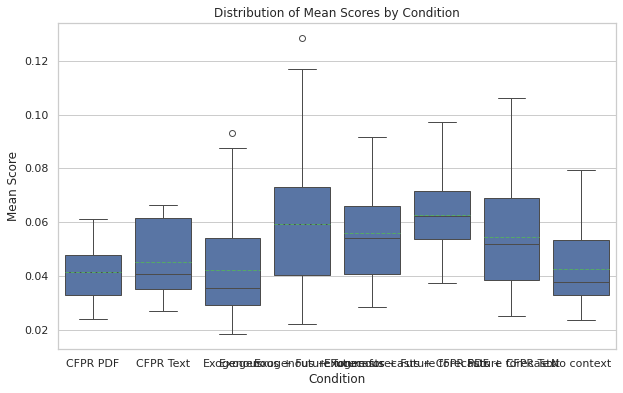

In [174]:
# What if we aggregate across all of the food categories
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a boxplot to show the distribution of mean_score across conditions
plt.figure(figsize=(10, 6))
sns.boxplot(data=mape_df, x='inclusion', y='mean_score', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Condition")
plt.xlabel("Condition")
plt.ylabel("Mean Score")

# Show plot
plt.show()

## By individiual food category

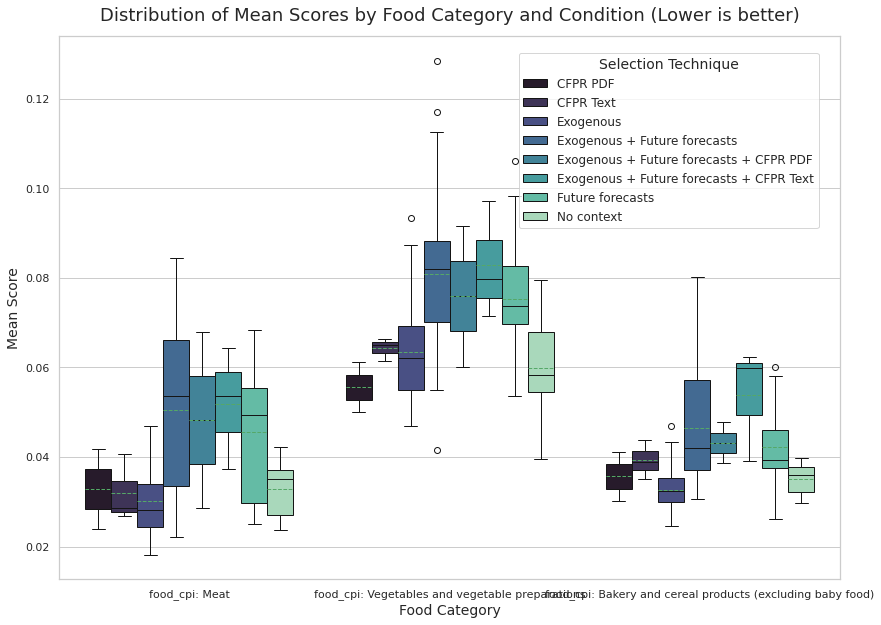

In [175]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the Seaborn theme and use the "mako" gradient palette
sns.set_theme(style="whitegrid")
gradient_palette = sns.color_palette("mako", n_colors=mape_df['inclusion'].nunique())

# Create the boxplot with flipped axes
plt.figure(figsize=(14, 10))
sns.boxplot(data=mape_df, x='category', y='mean_score', hue='inclusion', showmeans=True, meanline=True, palette=gradient_palette)

# Customize plot title and labels with larger font sizes
plt.title("Distribution of Mean Scores by Food Category and Condition (Lower is better)", fontsize=18, pad=15)
plt.ylabel("Mean Score", fontsize=14)
plt.xlabel("Food Category", fontsize=14)

# Position legend outside the plot for better readability
plt.legend(title='Selection Technique', loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=12, title_fontsize=14, frameon=True)

# Display the plot
plt.show()


In [176]:
import pandas as pd

# Assuming mape_df is the DataFrame with 'model', 'inclusion', and 'mean_score'

# Group by 'model' and 'inclusion' to calculate mean and std
pivot_table = mape_df.groupby(['model', 'category'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
pivot_table['mean_std'] = pivot_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to get 'inclusion' as columns
pivot_table = pivot_table.pivot(index='model', columns='category', values='mean_std').reset_index()



# Display the final pivot table
pivot_table.set_index('model')


category,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Meat,food_cpi: Vegetables and vegetable preparations
model,,,
Claude-3.5-Sonnet,0.034 ± 0.005,0.027 ± 0.005,0.064 ± 0.010
GPT 4.o,0.045 ± 0.011,0.052 ± 0.015,0.073 ± 0.010
Gemini 1.5 Pro,0.042 ± 0.012,0.044 ± 0.014,0.080 ± 0.018
llama 3.1 70B,0.030 ± 0.003,0.027 ± 0.004,0.050 ± 0.014


In [177]:
mape_df = mape_df.reset_index()

In [178]:

# Group by 'category', 'type', and 'inclusion' to calculate mean and std
summary_table = mape_df.groupby(['category', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
summary_table['mean_std'] = summary_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to have each inclusion condition as a column
summary_table_pivot = summary_table.pivot(index=['category'], columns='inclusion', values='mean_std').reset_index()

# Reorder the columns to match the specified order
order = ['No context', 'Exogenous', 'Future forecasts', 'CFPR Text', 'CFPR PDF']
summary_table_pivot = summary_table_pivot[['category'] + order]

# Display the table with a hierarchical index on 'category' and 'type'
summary_table_final = summary_table_pivot.set_index(['category'])

# Display the final table
summary_table_final

inclusion,No context,Exogenous,Future forecasts,CFPR Text,CFPR PDF
category,,,,,
food_cpi: Bakery and cereal products (excluding baby food),0.035 ± 0.003,0.033 ± 0.005,0.042 ± 0.008,0.039 ± 0.004,0.036 ± 0.008
food_cpi: Meat,0.033 ± 0.006,0.030 ± 0.008,0.046 ± 0.015,0.032 ± 0.008,0.033 ± 0.013
food_cpi: Vegetables and vegetable preparations,0.060 ± 0.011,0.063 ± 0.010,0.075 ± 0.013,0.064 ± 0.003,0.056 ± 0.008


In [179]:
summary_table

,category,inclusion,mean,std,mean_std
0,food_cpi: Bakery and cereal products (excludin...,CFPR PDF,0.035691,0.007721,0.036 ± 0.008
1,food_cpi: Bakery and cereal products (excludin...,CFPR Text,0.039290,0.004345,0.039 ± 0.004
2,food_cpi: Bakery and cereal products (excludin...,Exogenous,0.032728,0.004811,0.033 ± 0.005
3,food_cpi: Bakery and cereal products (excludin...,Exogenous + Future forecasts,0.046440,0.012934,0.046 ± 0.013
4,food_cpi: Bakery and cereal products (excludin...,Exogenous + Future forecasts + CFPR PDF,0.043156,0.006502,0.043 ± 0.007
5,food_cpi: Bakery and cereal products (excludin...,Exogenous + Future forecasts + CFPR Text,0.053763,0.012757,0.054 ± 0.013
6,food_cpi: Bakery and cereal products (excludin...,Future forecasts,0.042237,0.008464,0.042 ± 0.008
7,food_cpi: Bakery and cereal products (excludin...,No context,0.035163,0.003483,0.035 ± 0.003
8,food_cpi: Meat,CFPR PDF,0.032803,0.012633,0.033 ± 0.013
9,food_cpi: Meat,CFPR Text,0.032039,0.007532,0.032 ± 0.008


## Comparing by model

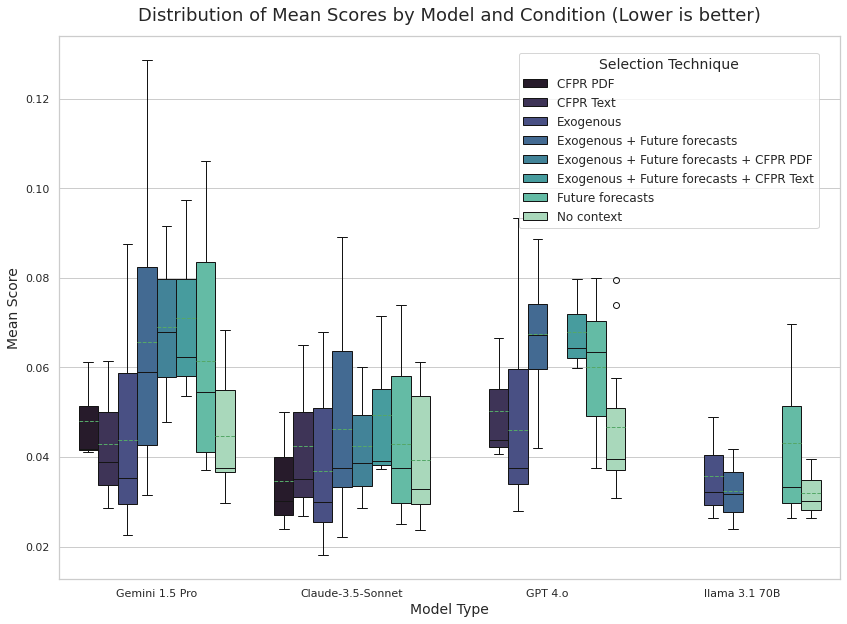

In [180]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the Seaborn theme and use the "mako" gradient palette
sns.set_theme(style="whitegrid")
gradient_palette = sns.color_palette("mako", n_colors=mape_df['inclusion'].nunique())

# Create the boxplot with flipped axes
plt.figure(figsize=(14, 10))
sns.boxplot(data=mape_df, x='model', y='mean_score', hue='inclusion', showmeans=True, meanline=True, palette=gradient_palette)

# Customize plot title and labels with larger font sizes
plt.title("Distribution of Mean Scores by Model and Condition (Lower is better)", fontsize=18, pad=15)
plt.ylabel("Mean Score", fontsize=14)
plt.xlabel("Model Type", fontsize=14)

# Position legend outside the plot for better readability
plt.legend(title='Selection Technique', loc='upper right', bbox_to_anchor=(0.98, 0.98), fontsize=12, title_fontsize=14, frameon=True)

# Display the plot
plt.show()


In [181]:
mape_df.groupby(['model', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    median='median'
).reset_index()

,model,inclusion,mean,std,min,max,median
0,Claude-3.5-Sonnet,CFPR PDF,0.034689,0.013605,0.023871,0.049963,0.030232
1,Claude-3.5-Sonnet,CFPR Text,0.042364,0.020124,0.026836,0.065100,0.035158
2,Claude-3.5-Sonnet,Exogenous,0.036826,0.016007,0.018198,0.067926,0.030013
3,Claude-3.5-Sonnet,Exogenous + Future forecasts,0.046297,0.019784,0.022041,0.089076,0.037494
4,Claude-3.5-Sonnet,Exogenous + Future forecasts + CFPR PDF,0.042449,0.016144,0.028605,0.060183,0.038558
5,Claude-3.5-Sonnet,Exogenous + Future forecasts + CFPR Text,0.049289,0.019178,0.037355,0.071411,0.039103
6,Claude-3.5-Sonnet,Future forecasts,0.042851,0.016112,0.024990,0.073855,0.037454
7,Claude-3.5-Sonnet,No context,0.039344,0.014264,0.023687,0.061153,0.032900
8,GPT 4.o,CFPR Text,0.050316,0.014062,0.040676,0.066452,0.043820
9,GPT 4.o,Exogenous,0.045930,0.016637,0.028034,0.093267,0.037499


In [182]:
import pandas as pd

# Assuming mape_df is the DataFrame containing your data

# Group by 'model' and 'inclusion' and calculate summary statistics for 'mean_score'
summary_table = mape_df.groupby(['model', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    median='median'
).reset_index()

# Display the table
summary_table


,model,inclusion,mean,std,min,max,median
0,Claude-3.5-Sonnet,CFPR PDF,0.034689,0.013605,0.023871,0.049963,0.030232
1,Claude-3.5-Sonnet,CFPR Text,0.042364,0.020124,0.026836,0.065100,0.035158
2,Claude-3.5-Sonnet,Exogenous,0.036826,0.016007,0.018198,0.067926,0.030013
3,Claude-3.5-Sonnet,Exogenous + Future forecasts,0.046297,0.019784,0.022041,0.089076,0.037494
4,Claude-3.5-Sonnet,Exogenous + Future forecasts + CFPR PDF,0.042449,0.016144,0.028605,0.060183,0.038558
5,Claude-3.5-Sonnet,Exogenous + Future forecasts + CFPR Text,0.049289,0.019178,0.037355,0.071411,0.039103
6,Claude-3.5-Sonnet,Future forecasts,0.042851,0.016112,0.024990,0.073855,0.037454
7,Claude-3.5-Sonnet,No context,0.039344,0.014264,0.023687,0.061153,0.032900
8,GPT 4.o,CFPR Text,0.050316,0.014062,0.040676,0.066452,0.043820
9,GPT 4.o,Exogenous,0.045930,0.016637,0.028034,0.093267,0.037499


In [183]:
import pandas as pd

# Assuming mape_df is the DataFrame with 'model', 'inclusion', and 'mean_score'

# Group by 'model' and 'inclusion' to calculate mean and std
pivot_table = mape_df.groupby(['model', 'inclusion'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
pivot_table['mean_std'] = pivot_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to get 'inclusion' as columns
pivot_table = pivot_table.pivot(index='model', columns='inclusion', values='mean_std').reset_index()

# Define the order of columns
order = ['No context','Exogenous', 'Future forecasts', 'CFPR Text', 'CFPR PDF']
# Reorder the columns based on the specified order
pivot_table = pivot_table[['model'] + order]

# Display the final pivot table
pivot_table.set_index('model')


inclusion,No context,Exogenous,Future forecasts,CFPR Text,CFPR PDF
model,,,,,
Claude-3.5-Sonnet,0.039 ± 0.014,0.037 ± 0.016,0.043 ± 0.016,0.042 ± 0.020,0.035 ± 0.014
GPT 4.o,0.047 ± 0.016,0.046 ± 0.017,0.060 ± 0.013,0.050 ± 0.014,NaN
Gemini 1.5 Pro,0.045 ± 0.013,0.044 ± 0.018,0.061 ± 0.022,0.043 ± 0.017,0.048 ± 0.011
llama 3.1 70B,0.032 ± 0.007,0.036 ± 0.012,0.043 ± 0.023,NaN,NaN


In [184]:
import pandas as pd

# Assuming mape_df is the DataFrame with 'model', 'inclusion', and 'mean_score'

# Group by 'model' and 'inclusion' to calculate mean and std
pivot_table = mape_df.groupby(['type', 'category'])['mean_score'].agg(
    mean='mean',
    std='std'
).reset_index()

# Format the mean and std as "mean ± std"
pivot_table['mean_std'] = pivot_table.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)

# Pivot the table to get 'inclusion' as columns
pivot_table = pivot_table.pivot(index='type', columns='category', values='mean_std').reset_index()

# # Define the order of columns
# order = ['Exogenous', 'Future forecasts + Exogenous', 'CFPR + Exogenous' , 'Future forecasts + CFPR + Exogenous']

# # Reorder the columns based on the specified order
# pivot_table = pivot_table[['model'] + order]

# Display the final pivot table
pivot_table.set_index('type')


category,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Meat,food_cpi: Vegetables and vegetable preparations
type,,,
Closed Source,0.040 ± 0.011,0.041 ± 0.016,0.072 ± 0.015
Open Source,0.030 ± 0.003,0.027 ± 0.004,0.050 ± 0.014


## Compare over time 

In [185]:
best_results_year = []

overall_mape = mape_df

for category in target_categories:
    # Filter rows for the current category
    category_rows =  overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(1000, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "mean_std": row["std_score"],
                "scores":row["scores"],
                "model":row["model"],
                "inclusion":row["inclusion"],
                "type":row["type"]


            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
best_results_year_df

,category,top_experiment,mean_score,mean_std,scores,model,inclusion,type
0,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20241022_exo_english_desc_Tr...,0.024580,0.013012,"[0.008400291211729988, 0.012534640482434078, 0...",Claude-3.5-Sonnet,Exogenous,Closed Source
1,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20241022_exo_english_desc_Tr...,0.025431,0.015019,"[0.008400291211729988, 0.009763635803330775, 0...",Claude-3.5-Sonnet,Exogenous,Closed Source
2,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20241022_exo_code_desc_True_...,0.025431,0.013861,"[0.01698488205359712, 0.010858207300862236, 0....",Claude-3.5-Sonnet,Exogenous,Closed Source
3,food_cpi: Bakery and cereal products (excludin...,gemini-1.5-pro_exo_english_desc_False_75_repor...,0.025591,0.013107,"[0.015779720013447237, 0.00949871639831297, 0....",Gemini 1.5 Pro,Exogenous,Closed Source
4,food_cpi: Bakery and cereal products (excludin...,gemini-1.5-pro_exo_english_desc_True_25_report...,0.026049,0.013495,"[0.01650551680121224, 0.009322040264232572, 0....",Gemini 1.5 Pro,Exogenous,Closed Source
...,...,...,...,...,...,...,...,...
433,food_cpi: Vegetables and vegetable preparations,gemini-1.5-pro_future_english_desc_True_full_r...,0.106017,0.048344,"[0.11559265417054977, 0.08585077828703931, 0.0...",Gemini 1.5 Pro,Future forecasts,Closed Source
434,food_cpi: Vegetables and vegetable preparations,gemini-1.5-pro_future_exo_code_desc_True_full_...,0.109331,0.045778,"[0.10721376217939549, 0.09142903741305351, 0.0...",Gemini 1.5 Pro,Exogenous + Future forecasts,Closed Source
435,food_cpi: Vegetables and vegetable preparations,gemini-1.5-pro_future_exo_code_desc_False_full...,0.112672,0.039751,"[0.12204909821550289, 0.10284058749192336, 0.0...",Gemini 1.5 Pro,Exogenous + Future forecasts,Closed Source
436,food_cpi: Vegetables and vegetable preparations,gemini-1.5-pro_future_exo_english_desc_True_fu...,0.117000,0.056340,"[0.11173366368982576, 0.1104835567713777, 0.04...",Gemini 1.5 Pro,Exogenous + Future forecasts,Closed Source


In [186]:
# Assuming your DataFrame is named 'best_results_year_df' and the column with MAPE lists is 'scores'
# Create a list to store each new row as a dictionary
rows = []

# Loop through each row in the original DataFrame
for index, row in best_results_year_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'experiment': row['top_experiment'],    # Retain experiment name
        'category': row['category'],            # Retain category
        'scores': row['scores'],                # Retain scores list
        'mean': row['mean_score'],              # Retain mean score
        'std': row['mean_std'],                 # Retain standard deviation
        'model': row['model'],                  # Retain model
        'inclusion': row['inclusion'],          # Retain inclusion
        'type': row['type']                     # Retain type
    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_' + report_sim_dates[i]] = score
    
    # Append the dictionary to the list of rows
    rows.append(new_row)

# Convert the list of rows into a DataFrame
expanded_df = pd.DataFrame(rows)

# Calculate 'eval_overall' and 'eval_std' columns as before
expanded_df['eval_overall'] = expanded_df['mean']
expanded_df['eval_std'] = expanded_df['std']

expanded_df


# Reorder the columns to match the specified order
order = ['No context', 'Exogenous', 'Future forecasts', 'CFPR Text', 'CFPR PDF']
expanded_df = expanded_df.loc[expanded_df.inclusion.isin(order)]
expanded_df


,experiment,category,scores,mean,std,model,inclusion,type,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01,eval_overall,eval_std
0,claude-3-5-sonnet-20241022_exo_english_desc_Tr...,food_cpi: Bakery and cereal products (excludin...,"[0.008400291211729988, 0.012534640482434078, 0...",0.024580,0.013012,Claude-3.5-Sonnet,Exogenous,Closed Source,0.008400,0.012535,0.037357,0.044930,0.019000,0.025256,0.024580,0.013012
1,claude-3-5-sonnet-20241022_exo_english_desc_Tr...,food_cpi: Bakery and cereal products (excludin...,"[0.008400291211729988, 0.009763635803330775, 0...",0.025431,0.015019,Claude-3.5-Sonnet,Exogenous,Closed Source,0.008400,0.009764,0.033285,0.052827,0.023051,0.025256,0.025431,0.015019
2,claude-3-5-sonnet-20241022_exo_code_desc_True_...,food_cpi: Bakery and cereal products (excludin...,"[0.01698488205359712, 0.010858207300862236, 0....",0.025431,0.013861,Claude-3.5-Sonnet,Exogenous,Closed Source,0.016985,0.010858,0.022887,0.054599,0.022000,0.025256,0.025431,0.013861
3,gemini-1.5-pro_exo_english_desc_False_75_repor...,food_cpi: Bakery and cereal products (excludin...,"[0.015779720013447237, 0.00949871639831297, 0....",0.025591,0.013107,Gemini 1.5 Pro,Exogenous,Closed Source,0.015780,0.009499,0.018654,0.046267,0.039609,0.023739,0.025591,0.013107
4,gemini-1.5-pro_exo_english_desc_True_25_report...,food_cpi: Bakery and cereal products (excludin...,"[0.01650551680121224, 0.009322040264232572, 0....",0.026049,0.013495,Gemini 1.5 Pro,Exogenous,Closed Source,0.016506,0.009322,0.046534,0.015526,0.039609,0.028797,0.026049,0.013495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,gemini-1.5-pro_future_english_desc_True_75_rep...,food_cpi: Vegetables and vegetable preparations,"[0.11155297519050272, 0.08121278596690727, 0.0...",0.088758,0.030142,Gemini 1.5 Pro,Future forecasts,Closed Source,0.111553,0.081213,0.038189,0.091530,0.134866,0.075199,0.088758,0.030142
425,gemini-1.5-pro_future_english_desc_True_10_rep...,food_cpi: Vegetables and vegetable preparations,"[0.11740593455041604, 0.07602283143048127, 0.0...",0.090307,0.028463,Gemini 1.5 Pro,Future forecasts,Closed Source,0.117406,0.076023,0.036285,0.092209,0.120637,0.099283,0.090307,0.028463
427,gpt-4o_exo_english_desc_False_full_report_Fals...,food_cpi: Vegetables and vegetable preparations,"[0.21020283518256963, 0.023601577772603924, 0....",0.093267,0.072210,GPT 4.o,Exogenous,Closed Source,0.210203,0.023602,0.027952,0.121335,0.150117,0.026392,0.093267,0.072210
430,gemini-1.5-pro_future_english_desc_False_full_...,food_cpi: Vegetables and vegetable preparations,"[0.1167580497321289, 0.023313872650851542, 0.0...",0.098210,0.050229,Gemini 1.5 Pro,Future forecasts,Closed Source,0.116758,0.023314,0.050924,0.107402,0.180103,0.110760,0.098210,0.050229


# Figure 6.6 

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):
    # Ensure 'model' and 'inclusion' columns are set up as a MultiIndex for hierarchical y-axis labels
    if 'model' in df.columns and 'inclusion' in df.columns:
#         df.set_index(['model', 'inclusion'], inplace=True)
        df.set_index(category, inplace=True)

    # Select columns related to evaluation windows and rename them
    eval_columns = [col for col in df.columns if 'eval_window_' in col]
    df = df[eval_columns + ['mean', 'std']]  # Include mean and std columns if present
    
    # Rename columns to remove "eval_window_" prefix and bold "Mean" and "Standard Deviation"
    df.columns = [col.replace('eval_window_', '') if 'eval_window_' in col else col for col in df.columns]
    df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)

    # Create the heatmap with the 'Blues' color palette for a clean aesthetic
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(
        df, annot=True, cmap='Blues', linewidths=0.3, fmt=".3f",
        annot_kws={"size": 9, "color": "black"},  # Adjust font size and color for annotations
        cbar_kws={"label": "MAPE", "orientation": "vertical"}  # Label the color bar
    )

    # Set the title and labels with bold font and larger font sizes
#     plt.title(f'Comparing Performance of Open and Closed Source Models', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Evaluation Windows', fontsize=14, fontweight='bold', labelpad=10)
    plt.ylabel("Context Inclusion", fontsize=14, fontweight='bold', labelpad=75, rotation=0)

    # Rotate x-axis labels for readability and adjust their font size
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11, rotation=0)
    plt.savefig('./Fig66.pdf', bbox_inches='tight')

    # Show the heatmap
    plt.show()


/tmp/ipykernel_1517/2106408.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)


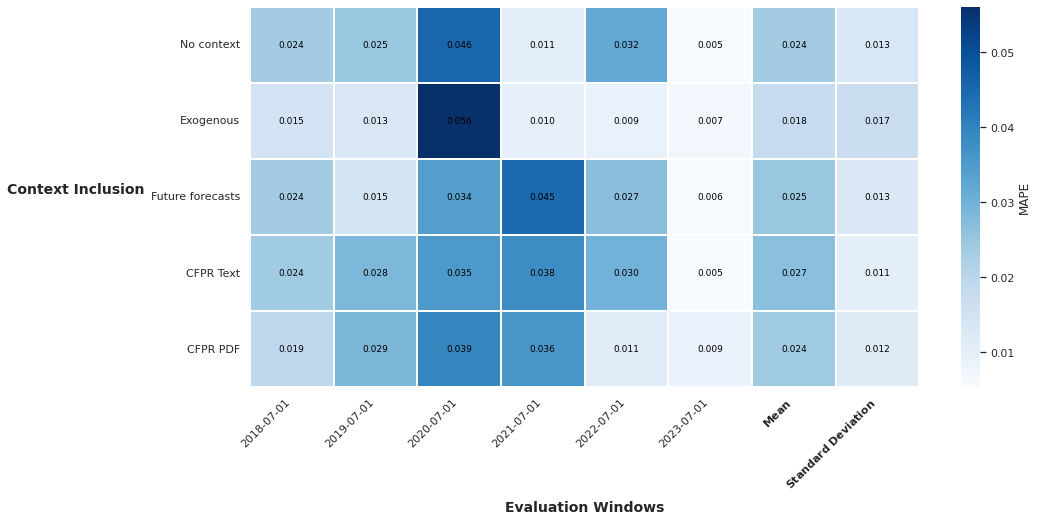

In [188]:
# Step 1: Group by 'inclusion' and filter to keep only those with both "Open Source" and "Close Source" types
filtered_df = expanded_df.groupby('inclusion').filter(lambda x: set(x['type']) == {'Open Source', 'Closed Source'})

# Display the filtered DataFrame
filtered_df = expanded_df

best_df = expanded_df.loc[expanded_df.groupby(['inclusion'])['mean'].idxmin()]

best_df["type_inclusion"] = best_df["type"] + " - " + best_df["inclusion"]

order = ['No context', 'Exogenous', 'Future forecasts', 'CFPR Text', 'CFPR PDF']
best_df['inclusion'] = pd.Categorical(best_df['inclusion'], categories=order, ordered=True)

best_df = best_df.sort_values(by='inclusion', ascending=True)

# average_df = expanded_df.groupby(['type', 'inclusion'], as_index=False)['mean'].mean()

plot_category(best_df, 'inclusion')

# Figure 6.7 

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):
    # Ensure 'model' and 'inclusion' columns are set up as a MultiIndex for hierarchical y-axis labels
    if 'model' in df.columns and 'inclusion' in df.columns:
#         df.set_index(['model', 'inclusion'], inplace=True)
        df.set_index(category, inplace=True)

    # Select columns related to evaluation windows and rename them
    eval_columns = [col for col in df.columns if 'eval_window_' in col]
    df = df[eval_columns + ['mean', 'std']]  # Include mean and std columns if present
    
    # Rename columns to remove "eval_window_" prefix and bold "Mean" and "Standard Deviation"
    df.columns = [col.replace('eval_window_', '') if 'eval_window_' in col else col for col in df.columns]
    df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)

    # Create the heatmap with the 'Blues' color palette for a clean aesthetic
    plt.figure(figsize=(15, 7))
    ax = sns.heatmap(
        df, annot=True, cmap='Blues', linewidths=0.3, fmt=".3f",
        annot_kws={"size": 9, "color": "black"},  # Adjust font size and color for annotations
        cbar_kws={"label": "MAPE", "orientation": "vertical"}  # Label the color bar
    )

    # Set the title and labels with bold font and larger font sizes
#     plt.title(f'Comparing Performance of Open and Closed Source Models', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Evaluation Windows', fontsize=14, fontweight='bold', labelpad=10)
    plt.ylabel("Context Inclusion", fontsize=14, fontweight='bold', labelpad=75, rotation=0)

    # Rotate x-axis labels for readability and adjust their font size
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11, rotation=0)
    plt.savefig('./Fig67.pdf', bbox_inches='tight')

    # Show the heatmap
    plt.show()


/tmp/ipykernel_1517/3058958959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'mean': r'$\mathbf{Mean}$', 'std': r'$\mathbf{Standard\ Deviation}$'}, inplace=True)


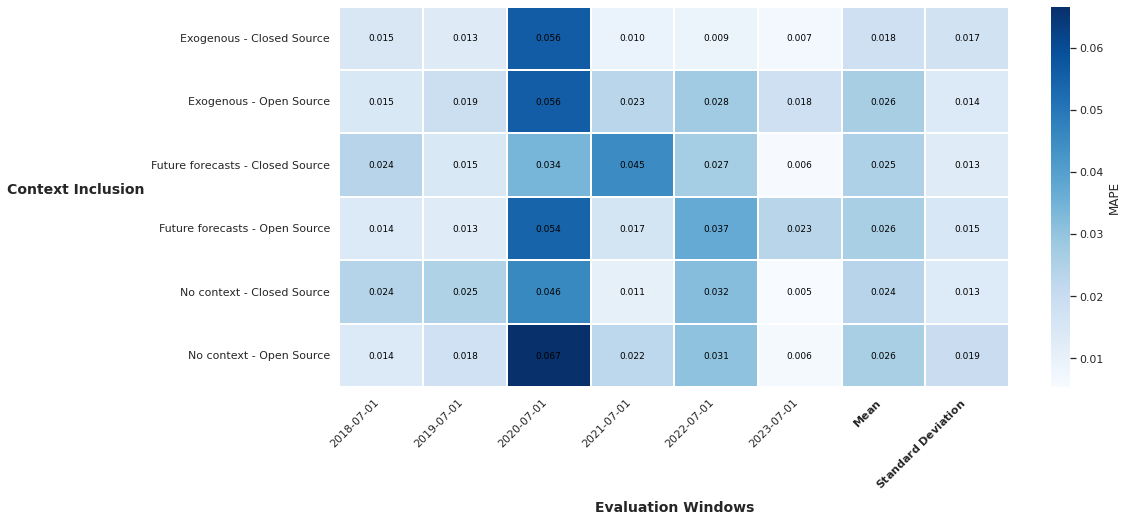

In [207]:
# Step 1: Group by 'inclusion' and filter to keep only those with both "Open Source" and "Close Source" types
filtered_df = expanded_df.groupby('inclusion').filter(lambda x: set(x['type']) == {'Open Source', 'Closed Source'})

# Display the filtered DataFrame
filtered_df = expanded_df

best_df = expanded_df.loc[expanded_df.groupby(['type','inclusion'])['mean'].idxmin()]





best_df['inclusion'] = pd.Categorical(best_df['inclusion'], categories=order, ordered=True)

best_df = expanded_df.loc[expanded_df.groupby(['type','inclusion'])['mean'].idxmin()]

best_df["type_inclusion"] = best_df["inclusion"] + " - " + best_df["type"]


best_df = best_df.sort_values(by='inclusion', ascending=True)

order = ['No context', 'Exogenous', 'Future forecasts']
best_df = best_df.loc[best_df['inclusion'].isin(order)]
best_df

# average_df = expanded_df.groupby(['type', 'inclusion'], as_index=False)['mean'].mean()

plot_category(best_df, 'type_inclusion')

In [194]:
best_df

,experiment,category,scores,mean,std,model,inclusion,type,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01,eval_overall,eval_std
type_inclusion,,,,,,,,,,,,,,,,
NaN,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.01919354460554802, 0.02869972018201535, 0.0...",0.023871,0.011694,Claude-3.5-Sonnet,CFPR PDF,Closed Source,0.019194,0.028700,0.039332,0.036024,0.011224,0.008751,0.023871,0.011694
NaN,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.024015914520520973, 0.028494418465650425, 0...",0.026836,0.010644,Claude-3.5-Sonnet,CFPR Text,Closed Source,0.024016,0.028494,0.035351,0.038046,0.029772,0.005335,0.026836,0.010644
NaN,claude-3-5-sonnet-20241022_exo_english_desc_Fa...,food_cpi: Meat,"[0.0146548056241331, 0.013186327132804206, 0.0...",0.018198,0.017162,Claude-3.5-Sonnet,Exogenous,Closed Source,0.014655,0.013186,0.056115,0.009524,0.008985,0.006721,0.018198,0.017162
NaN,claude-3-5-sonnet-20241022_future_english_desc...,food_cpi: Meat,"[0.023572462470097644, 0.01453149546663031, 0....",0.024990,0.012728,Claude-3.5-Sonnet,Future forecasts,Closed Source,0.023572,0.014531,0.034093,0.044989,0.027087,0.005669,0.024990,0.012728
NaN,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.0237576362605611, 0.02494381024934646, 0.04...",0.023687,0.013254,Claude-3.5-Sonnet,No context,Closed Source,0.023758,0.024944,0.045589,0.010699,0.031823,0.005308,0.023687,0.013254
NaN,llama-3.1-70B_exo_english_desc_False_75_item,food_cpi: Meat,"[0.014549607895751913, 0.018875458389735214, 0...",0.026421,0.013823,llama 3.1 70B,Exogenous,Open Source,0.014550,0.018875,0.055888,0.023228,0.027814,0.018169,0.026421,0.013823
NaN,llama-3.1-70B_future_english_desc_False_75_item,food_cpi: Bakery and cereal products (excludin...,"[0.013710346907131918, 0.01252322956640991, 0....",0.026262,0.014979,llama 3.1 70B,Future forecasts,Open Source,0.013710,0.012523,0.054196,0.016559,0.037113,0.023471,0.026262,0.014979
NaN,llama-3.1-70B_price_english_desc_False_75_item,food_cpi: Meat,"[0.013763048167663832, 0.017885491499252608, 0...",0.026283,0.019499,llama 3.1 70B,No context,Open Source,0.013763,0.017885,0.066615,0.022404,0.030588,0.006442,0.026283,0.019499


In [190]:
best_df

,experiment,category,scores,mean,std,model,inclusion,type,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01,eval_overall,eval_std
type_inclusion,,,,,,,,,,,,,,,,
Closed Source - CFPR PDF,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.01919354460554802, 0.02869972018201535, 0.0...",0.023871,0.011694,Claude-3.5-Sonnet,NaN,Closed Source,0.019194,0.028700,0.039332,0.036024,0.011224,0.008751,0.023871,0.011694
Closed Source - CFPR Text,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.024015914520520973, 0.028494418465650425, 0...",0.026836,0.010644,Claude-3.5-Sonnet,NaN,Closed Source,0.024016,0.028494,0.035351,0.038046,0.029772,0.005335,0.026836,0.010644
Closed Source - Exogenous,claude-3-5-sonnet-20241022_exo_english_desc_Fa...,food_cpi: Meat,"[0.0146548056241331, 0.013186327132804206, 0.0...",0.018198,0.017162,Claude-3.5-Sonnet,NaN,Closed Source,0.014655,0.013186,0.056115,0.009524,0.008985,0.006721,0.018198,0.017162
Closed Source - Future forecasts,claude-3-5-sonnet-20241022_future_english_desc...,food_cpi: Meat,"[0.023572462470097644, 0.01453149546663031, 0....",0.024990,0.012728,Claude-3.5-Sonnet,NaN,Closed Source,0.023572,0.014531,0.034093,0.044989,0.027087,0.005669,0.024990,0.012728
Closed Source - No context,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.0237576362605611, 0.02494381024934646, 0.04...",0.023687,0.013254,Claude-3.5-Sonnet,NaN,Closed Source,0.023758,0.024944,0.045589,0.010699,0.031823,0.005308,0.023687,0.013254
Open Source - Exogenous,llama-3.1-70B_exo_english_desc_False_75_item,food_cpi: Meat,"[0.014549607895751913, 0.018875458389735214, 0...",0.026421,0.013823,llama 3.1 70B,NaN,Open Source,0.014550,0.018875,0.055888,0.023228,0.027814,0.018169,0.026421,0.013823
Open Source - Future forecasts,llama-3.1-70B_future_english_desc_False_75_item,food_cpi: Bakery and cereal products (excludin...,"[0.013710346907131918, 0.01252322956640991, 0....",0.026262,0.014979,llama 3.1 70B,NaN,Open Source,0.013710,0.012523,0.054196,0.016559,0.037113,0.023471,0.026262,0.014979
Open Source - No context,llama-3.1-70B_price_english_desc_False_75_item,food_cpi: Meat,"[0.013763048167663832, 0.017885491499252608, 0...",0.026283,0.019499,llama 3.1 70B,NaN,Open Source,0.013763,0.017885,0.066615,0.022404,0.030588,0.006442,0.026283,0.019499


In [191]:
# Define the desired order for 'inclusion'
order = ['No context', 'Exogenous', 'Future forecasts', 'CFPR Text', 'CFPR PDF']

# Filter the DataFrame to only include rows where 'inclusion' is in the order list
filtered_df = expanded_df[expanded_df['inclusion'].isin(order)]

# Optional: Sort the DataFrame to respect the order of 'inclusion'
filtered_df['inclusion'] = pd.Categorical(filtered_df['inclusion'], categories=order, ordered=True)
filtered_df = filtered_df.sort_values('inclusion')
filtered_df

,experiment,category,scores,mean,std,model,inclusion,type,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01,eval_overall,eval_std
201,gpt-4o_price_english_desc_False_10_report_Fals...,food_cpi: Meat,"[0.021143107877114327, 0.015475881089058893, 0...",0.030772,0.019737,GPT 4.o,No context,Closed Source,0.021143,0.015476,0.040716,0.031315,0.068051,0.007930,0.030772,0.019737
328,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Vegetables and vegetable preparations,"[0.039834058279789204, 0.1496479583064993, 0.0...",0.060294,0.043882,Claude-3.5-Sonnet,No context,Closed Source,0.039834,0.149648,0.071956,0.055430,0.030408,0.014487,0.060294,0.043882
56,gpt-4o_price_english_desc_False_10_report_Fals...,food_cpi: Bakery and cereal products (excludin...,"[0.013430441204389115, 0.012321739589492913, 0...",0.035342,0.025555,GPT 4.o,No context,Closed Source,0.013430,0.012322,0.045866,0.086772,0.024866,0.028797,0.035342,0.025555
319,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Vegetables and vegetable preparations,"[0.1050001711721079, 0.0371850693903211, 0.032...",0.058267,0.031123,Claude-3.5-Sonnet,No context,Closed Source,0.105000,0.037185,0.032764,0.075995,0.081415,0.017245,0.058267,0.031123
316,gpt-4o_price_english_desc_False_75_report_Fals...,food_cpi: Vegetables and vegetable preparations,"[0.1027652180218453, 0.069462493403769, 0.0279...",0.057700,0.027254,GPT 4.o,No context,Closed Source,0.102765,0.069462,0.027944,0.072738,0.048675,0.024615,0.057700,0.027254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Meat,"[0.01919354460554802, 0.02869972018201535, 0.0...",0.023871,0.011694,Claude-3.5-Sonnet,CFPR PDF,Closed Source,0.019194,0.028700,0.039332,0.036024,0.011224,0.008751,0.023871,0.011694
300,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Vegetables and vegetable preparations,"[0.1015066183648539, 0.047666020667040156, 0.0...",0.049963,0.027507,Claude-3.5-Sonnet,CFPR PDF,Closed Source,0.101507,0.047666,0.032332,0.061969,0.043509,0.012798,0.049963,0.027507
238,gemini-1.5-pro_price_english_desc_False_75_rep...,food_cpi: Meat,"[0.024198927121357974, 0.07902638927753902, 0....",0.041736,0.024327,Gemini 1.5 Pro,CFPR PDF,Closed Source,0.024199,0.079026,0.043810,0.063182,0.035139,0.005061,0.041736,0.024327
18,claude-3-5-sonnet-20241022_price_english_desc_...,food_cpi: Bakery and cereal products (excludin...,"[0.015160684373173246, 0.01547205928530672, 0....",0.030232,0.019137,Claude-3.5-Sonnet,CFPR PDF,Closed Source,0.015161,0.015472,0.019902,0.066009,0.019081,0.045765,0.030232,0.019137


In [192]:
best_df2 = filtered_df.loc[filtered_df.groupby(['type','inclusion'])['mean'].idxmin()]

# best_df2 = best_df.groupby(['inclusion'], as_index=False).mean()

plot_category(best_df2, 'inclusion')

KeyError: '[nan] not in index'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):
    # Select only columns related to evaluation windows
    eval_columns = [col for col in df.columns if 'eval_window_' in col]

    # If no evaluation columns exist, use all numeric columns
    if not eval_columns:
        eval_columns = df.select_dtypes(include=['number']).columns.tolist()

    # Filter the DataFrame to only include relevant columns
    df = df[eval_columns] if eval_columns else df

    # Create the heatmap with the 'Blues' color palette for a clean aesthetic
    plt.figure(figsize=(7, 7))
    ax = sns.heatmap(
        df, annot=True, cmap='Blues', linewidths=0.3, fmt=".3f",
        annot_kws={"size": 9, "color": "black"},  # Adjust font size and color for annotations
        cbar_kws={"label": "Score", "orientation": "vertical"}  # Label the color bar
    )

    # Set the title and labels with bold font and larger font sizes
    plt.title(f'Comparing Performance of Open and Closed Source Models', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Evaluation Windows', fontsize=14, fontweight='bold', labelpad=10)
    plt.ylabel("Type - Inclusion", fontsize=14, fontweight='bold', labelpad=10)

    # Rotate x-axis labels for readability and adjust their font size
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)

    # Show the heatmap
    plt.show()



In [ ]:
filtered_df

In [ ]:
filtered_df

In [ ]:
best_df

In [ ]:
df_filt